# Expected Threat Model Focused on Attacking Midfielders



# Importing Libraries
This cell imports libraries for data processing, modeling, and visualization.


In [1]:
# Cell 1: Imports and Setup + Model Description

"""
Expected Threat (xT) Model for Attacking Midfielders

This model evaluates attacking midfielders based on their ability to progress play and create chances
by combining several key metrics:

Key Features:
1. Progressive passing - Moving the ball forward into dangerous areas
2. Final third success - Completing passes in attacking areas
3. Key passes - Creating direct chances
4. Box entries - Getting the ball into dangerous areas
5. Successful passes - Overall passing ability
6. Attacking third presence - Involvement in advanced areas

The model weights these features based on their importance to chance creation and assigns
an xT value to each action. This helps identify players who consistently contribute to
attacking moves in valuable ways.

Assumptions:
- Valuable actions are those that progress play or create chances
- Middle-to-final third progression is particularly important
- Both direct (key passes) and indirect (progression) chance creation matter
- Ball retention (passing success) supports attacking play
"""

# Imports
import os
import json
import pathlib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from mplsoccer import Pitch

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Loading Data
This function loads Wyscout events and player data from JSON files, and the data is loaded immediately afterward.


In [2]:
def load_premier_league_data():
    """Load and prepare Premier League player and event data"""
    # Load players
    with open('players.json') as f:
        players_data = json.load(f)
    df_players = pd.DataFrame(players_data)
    
    # Clean player names early
    for col in ['firstName', 'lastName', 'shortName']:
        df_players[col] = df_players[col].apply(
            lambda x: x.encode('latin1').decode('unicode_escape') 
            if isinstance(x, str) else x
        )
    
    # Load Premier League events
    with open('events_England.json') as f:
        events_data = json.load(f)
    df_events = pd.DataFrame(events_data)
    
    # Calculate matches and minutes
    player_matches = df_events.groupby('playerId')['matchId'].nunique().reset_index()
    player_matches.columns = ['playerId', 'num_matches']
    player_matches['minutes_played'] = player_matches['num_matches'] * 90
    
    # Basic player filtering for midfielders
    df_players = df_players.rename(columns={'wyId': 'playerId'})
    midfielder_mask = df_players['role'].apply(lambda x: 
        isinstance(x, dict) and x.get('name') == 'Midfielder'
    )
    df_players = df_players[midfielder_mask].copy()
    
    # Merge minutes with players data
    df_players = df_players.merge(player_matches[['playerId', 'minutes_played', 'num_matches']], 
                                how='left', 
                                on='playerId')
    
    # Filter for minimum minutes (400)
    df_players = df_players[df_players['minutes_played'] > 400].copy()
    
    print(f"Loaded {len(df_events)} events and {len(df_players)} midfielders")
    print("\nMinutes statistics:")
    print(df_players['minutes_played'].describe())
    
    return df_players, df_events

df_players, df_events = load_premier_league_data()

Loaded 643150 events and 166 midfielders

Minutes statistics:
count     166.000000
mean     2125.843373
std       897.681296
min       450.000000
25%      1350.000000
50%      2340.000000
75%      2970.000000
max      3420.000000
Name: minutes_played, dtype: float64


# Arsenal Play style

In [3]:
def analyze_arsenal_style(df_events):
    """Analyze Arsenal's playing style and needs"""
    arsenal_team_id = 1609  # Arsenal's team ID
    arsenal_events = df_events[df_events['teamId'] == arsenal_team_id].copy()
    
    # Filter relevant events
    arsenal_style = arsenal_events[
        arsenal_events['eventName'].isin(['Pass', 'Shot', 'Free Kick'])
    ].copy()
    
    # Add coordinates for analysis
    for pos in ['start', 'end']:
        idx = 0 if pos == 'start' else 1
        for coord in ['x', 'y']:
            col = f"{pos}_{coord}"
            arsenal_style[col] = arsenal_style['positions'].apply(
                lambda x: x[idx]['x'] if coord == 'x' else x[idx]['y'] if len(x) > idx else None
            )
    
    # Calculate key metrics
    arsenal_metrics = {
        'avg_pass_length': np.mean(np.sqrt(
            (arsenal_style['end_x'] - arsenal_style['start_x'])**2 +
            (arsenal_style['end_y'] - arsenal_style['start_y'])**2
        )),
        'forward_pass_ratio': np.mean(arsenal_style['end_x'] > arsenal_style['start_x']),
        'final_third_entries': np.mean(arsenal_style['end_x'] >= 70),
        'central_play': np.mean(
            (arsenal_style['end_y'] >= 24) & 
            (arsenal_style['end_y'] <= 44)
        )
    }
    
    print("\nArsenal Playing Style Analysis:")
    print("-" * 40)
    print(f"Average Pass Length: {arsenal_metrics['avg_pass_length']:.2f}")
    print(f"Forward Pass Ratio: {arsenal_metrics['forward_pass_ratio']:.2%}")
    print(f"Final Third Entries Ratio: {arsenal_metrics['final_third_entries']:.2%}")
    print(f"Central Play Ratio: {arsenal_metrics['central_play']:.2%}")
    
    return arsenal_metrics

arsenal_metrics = analyze_arsenal_style(df_events)


Arsenal Playing Style Analysis:
----------------------------------------
Average Pass Length: 25.31
Forward Pass Ratio: 60.97%
Final Third Entries Ratio: 30.65%
Central Play Ratio: 22.95%


# Feature Engineering

In [4]:
def create_features(df_events, df_players):
    """Create features for the xT model with refined CAM-specific metrics"""
    print("Starting feature creation...")
    
    player_ids = set(df_players['playerId'])
    df = df_events[df_events['playerId'].isin(player_ids)].copy()
    
    print(f"Processing {len(df)} relevant events...")
    
    # Add coordinates with better error handling
    def get_position(positions, idx, coord):
        try:
            if positions and len(positions) > idx:
                return positions[idx][coord]
            return None
        except (IndexError, KeyError, TypeError):
            return None
    
    # Add coordinates
    for pos in ['start', 'end']:
        idx = 0 if pos == 'start' else 1
        for coord in ['x', 'y']:
            col = f"{pos}_{coord}"
            df[col] = df['positions'].apply(lambda x: get_position(x, idx, coord))
    
    df = df.dropna(subset=['start_x', 'start_y', 'end_x', 'end_y'])
    
    # Progressive Features
    df['forward_progress'] = df['end_x'] - df['start_x']
    df['middle_third_progressive'] = (
        (df['start_x'].between(33.3, 66.6)) &  # Middle third
        (df['forward_progress'] > 10) &  # Progressive
        (df['eventName'] == 'Pass')
    ).astype(int)
    
    # Final Third Success
    df['final_third_success'] = (
        (df['end_x'] >= 70) &  # Final third
        (df['eventName'] == 'Pass') & 
        (~df['tags'].apply(lambda x: any(tag['id'] == 1802 for tag in x)))  # Successful
    ).astype(int)
    
    # Dribbling Feature
    df['successful_dribble'] = df['tags'].apply(
        lambda x: any(tag['id'] == 1102 for tag in x)  # Successful dribble tag
    ).astype(int)
    
    # Pass Features
    df['attacking_third'] = (df['end_x'] >= 70).astype(int)
    df['successful_pass'] = df['tags'].apply(
        lambda x: not any(tag['id'] == 1802 for tag in x)
    ).astype(int)
    
    df['key_pass'] = df['tags'].apply(
        lambda x: any(tag['id'] in [301, 302] for tag in x)
    ).astype(int)
    
    # Box Entry
    df['box_entry'] = (
        (df['end_x'] >= 80) & 
        (abs(df['end_y'] - 34) <= 20)
    ).astype(int)
    
    # Calculate xT
    df['xT'] = (
        0.1995 * df['middle_third_progressive'] +
        0.1559 * df['key_pass'] +
        0.1543 * df['final_third_success'] +
        0.1497 * df['successful_pass'] +
        0.1496 * df['attacking_third'] +
        0.1000 * df['successful_dribble'] +
        0.05 * df['box_entry']
    )
    
    print("Feature creation complete.")
    return df

# Run feature creation
df_features = create_features(df_events, df_players)
print("\nFeature Statistics:")
print(df_features[['middle_third_progressive', 'final_third_success', 'key_pass', 
                   'successful_pass', 'attacking_third', 'successful_dribble', 
                   'box_entry', 'xT']].describe())

Starting feature creation...
Processing 235585 relevant events...
Feature creation complete.

Feature Statistics:
       middle_third_progressive  final_third_success       key_pass  successful_pass  attacking_third  successful_dribble      box_entry             xT
count             235532.000000        235532.000000  235532.000000    235532.000000    235532.000000       235532.000000  235532.000000  235532.000000
mean                   0.094875             0.140125       0.006547         0.772082         0.318139            0.000025       0.062917       0.207892
std                    0.293042             0.347118       0.080648         0.419490         0.465755            0.005047       0.242814       0.155211
min                    0.000000             0.000000       0.000000         0.000000         0.000000            0.000000       0.000000       0.000000
25%                    0.000000             0.000000       0.000000         1.000000         0.000000            0.000000     

# Model Training



In [5]:
def train_model(df_features):
    """Train refined xT model"""
    
    refined_features = [
        'middle_third_progressive',
        'final_third_success', 
        'key_pass',
        'successful_pass',
        'attacking_third',
        'successful_dribble',
        'box_entry'
    ]
    
    X = df_features[refined_features]
    y = df_features['xT']
    
    # Train model
    X_train = sm.add_constant(X)
    model = sm.OLS(y, X_train).fit()
    
    print("\nModel Summary:")
    print(model.summary().tables[1])
    
    return model, refined_features

# Run model training
model, feature_cols = train_model(df_features)
print("\nFeature Importance (coefficients):")
for feature, coef in zip(feature_cols, model.params[1:]):
    print(f"{feature}: {coef:.4f}")


Model Summary:
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     3.314e-16   8.91e-18     37.191      0.000    3.14e-16    3.49e-16
middle_third_progressive     0.1995   1.31e-17   1.52e+16      0.000       0.199       0.199
final_third_success          0.1543   1.45e-17   1.07e+16      0.000       0.154       0.154
key_pass                     0.1559   4.78e-17   3.26e+15      0.000       0.156       0.156
successful_pass              0.1497   9.53e-18   1.57e+16      0.000       0.150       0.150
attacking_third              0.1496   1.11e-17   1.35e+16      0.000       0.150       0.150
successful_dribble           0.1000   7.46e-16   1.34e+14      0.000       0.100       0.100
box_entry                    0.0500   1.71e-17   2.92e+15      0.000       0.050       0.050

Feature Importance (coefficients):
middle_third_progr

# Premier League player evaluation


In [6]:
def evaluate_players(df_features, model, feature_cols, df_players):
    """Evaluate players with refined metrics and proper error handling"""
    
    try:
        # Prepare features for prediction
        X = df_features[feature_cols].copy()
        X = sm.add_constant(X)
        df_features['predicted_xT'] = model.predict(X)
        
        # Calculate player metrics
        player_stats = df_features.groupby('playerId').agg({
            'predicted_xT': ['count', 'mean', 'sum'],
            'middle_third_progressive': 'sum',
            'final_third_success': 'sum',
            'successful_dribble': 'sum',
            'successful_pass': 'mean',
            'key_pass': 'sum',
            'attacking_third': 'sum',
            'box_entry': 'sum'
        }).round(3)
        
        # Flatten column names
        player_stats.columns = [
            'n_actions', 'avg_xT', 'total_xT',
            'progressive_passes', 'final_third_passes',
            'successful_dribbles', 'pass_success_rate',
            'key_passes', 'attacking_third_entries',
            'box_entries'
        ]
        
        # Add player info and minutes
        player_stats = player_stats.merge(
            df_players[['playerId', 'shortName', 'currentTeamId', 'minutes_played']], 
            left_index=True,
            right_on='playerId'
        )
        
        # Filter for minimum minutes
        player_stats = player_stats[player_stats['minutes_played'] > 400].copy()
        
        # Calculate per 90 stats
        for col in ['progressive_passes', 'final_third_passes', 'successful_dribbles', 
                    'key_passes', 'attacking_third_entries', 'box_entries']:
            player_stats[f'{col}_per90'] = (player_stats[col] * 90 / player_stats['minutes_played']).fillna(0)
        
        # Calculate composite score with error handling
        try:
            player_stats['composite_score'] = (
                0.30 * stats.zscore(player_stats['progressive_passes_per90'].fillna(0)) +
                0.20 * stats.zscore(player_stats['key_passes_per90'].fillna(0)) +
                0.15 * stats.zscore(player_stats['final_third_passes_per90'].fillna(0)) +
                0.15 * stats.zscore(player_stats['attacking_third_entries_per90'].fillna(0)) +
                0.10 * stats.zscore(player_stats['successful_dribbles_per90'].fillna(0)) +
                0.10 * stats.zscore(player_stats['box_entries_per90'].fillna(0))
            )
        except Exception as e:
            print(f"Warning: Error calculating composite score: {str(e)}")
            player_stats['composite_score'] = np.nan
        
        return player_stats
        
    except Exception as e:
        print(f"Error in player evaluation: {str(e)}")
        return pd.DataFrame()

# Run player evaluation
player_rankings = evaluate_players(df_features, model, feature_cols, df_players)

In [7]:
# Add this display code after evaluating player_rankings
print("\nTOP CAM RECOMMENDATIONS")
print("=" * 50)
print("\nTop 10 Players:")

for _, player in player_rankings.nlargest(10, 'composite_score').iterrows():
    print(f"\n{player['shortName']}")
    print(f"xT per Action: {player['avg_xT']:.3f}")
    print(f"Progressive Passes per 90: {player['progressive_passes_per90']:.1f}")
    print(f"Final Third Passes per 90: {player['final_third_passes_per90']:.1f}")
    print(f"Key Passes per 90: {player['key_passes_per90']:.1f}")
    print(f"Successful Dribbles per 90: {player['successful_dribbles_per90']:.1f}")
    print(f"Box Entries per 90: {player['box_entries_per90']:.1f}")
    print(f"Composite Score: {player['composite_score']:.3f}")

print("\nOverall Statistics (per 90):")
stats_cols = [col for col in player_rankings.columns if 'per90' in col]
print(player_rankings[stats_cols].describe())


TOP CAM RECOMMENDATIONS

Top 10 Players:

K. De Bruyne
xT per Action: 0.247
Progressive Passes per 90: 10.5
Final Third Passes per 90: 23.1
Key Passes per 90: 1.8
Successful Dribbles per 90: 0.0
Box Entries per 90: 10.9
Composite Score: 2.933

M. Özil
xT per Action: 0.264
Progressive Passes per 90: 8.0
Final Third Passes per 90: 28.0
Key Passes per 90: 1.4
Successful Dribbles per 90: 0.0
Box Entries per 90: 10.3
Composite Score: 2.345

Fàbregas
xT per Action: 0.252
Progressive Passes per 90: 14.5
Final Third Passes per 90: 19.4
Key Passes per 90: 1.1
Successful Dribbles per 90: 0.0
Box Entries per 90: 7.8
Composite Score: 2.136

David Silva
xT per Action: 0.253
Progressive Passes per 90: 9.4
Final Third Passes per 90: 27.7
Key Passes per 90: 0.7
Successful Dribbles per 90: 0.0
Box Entries per 90: 11.1
Composite Score: 2.070

C. Eriksen
xT per Action: 0.239
Progressive Passes per 90: 8.7
Final Third Passes per 90: 18.6
Key Passes per 90: 1.2
Successful Dribbles per 90: 0.0
Box Entries 

# Scout other leagues

In [8]:
def analyze_other_leagues():
    """Load and analyze players from other top leagues"""
    
    other_leagues = {
        'France': 'events_France.json',
        'Germany': 'events_Germany.json',
        'Italy': 'events_Italy.json',
        'Spain': 'events_Spain.json'
    }
    
    print("\nANALYZING OTHER TOP LEAGUES")
    print("=" * 50)
    
    all_league_stats = pd.DataFrame()
    
    for league_name, file_name in other_leagues.items():
        try:
            print(f"\nAnalyzing {league_name}...")
            
            # Load league data
            try:
                with open(file_name) as f:
                    league_data = json.load(f)
                df_league_events = pd.DataFrame(league_data)
                
                # Calculate matches and minutes for this league
                player_matches = df_league_events.groupby('playerId')['matchId'].nunique().reset_index()
                player_matches.columns = ['playerId', 'num_matches']
                player_matches['minutes_played'] = player_matches['num_matches'] * 90
                
                # Load and prepare players data
                with open('players.json') as f:
                    players_data = json.load(f)
                df_league_players = pd.DataFrame(players_data)
                
                # Clean player names
                for col in ['firstName', 'lastName', 'shortName']:
                    df_league_players[col] = df_league_players[col].apply(
                        lambda x: x.encode('latin1').decode('unicode_escape') 
                        if isinstance(x, str) else x
                    )
                
                # Filter midfielders for this league
                df_league_players = df_league_players[
                    df_league_players['role'].apply(lambda x: 
                        isinstance(x, dict) and x.get('name') == 'Midfielder'
                    )
                ].copy()
                
                # Rename ID column and merge minutes
                df_league_players = df_league_players.rename(columns={'wyId': 'playerId'})
                df_league_players = df_league_players.merge(
                    player_matches[['playerId', 'minutes_played', 'num_matches']], 
                    how='left', 
                    on='playerId'
                )
                
                # Filter for minimum minutes
                df_league_players = df_league_players[
                    df_league_players['minutes_played'] > 400
                ].copy()
                
                print(f"Starting feature creation...")
                print(f"Processing {len(df_league_events)} relevant events...")
                
                # Create features
                df_league_features = create_features(df_league_events, df_league_players)
                print("Feature creation complete.")
                
                # Calculate player stats
                league_stats = evaluate_players(df_league_features, model, feature_cols, df_league_players)
                league_stats['league'] = league_name
                
                # Append to all leagues dataframe
                all_league_stats = pd.concat([all_league_stats, league_stats])
                
                # Print top 3 from this league
                print(f"\nTop 3 {league_name} Targets:")
                print("-" * 40)
                top_players = league_stats.nlargest(3, 'composite_score')
                for _, player in top_players.iterrows():
                    print(f"\n{player['shortName']}")
                    print(f"xT per Action: {player['avg_xT']:.3f}")
                    print(f"Progressive Passes per 90: {player['progressive_passes_per90']:.1f}")
                    print(f"Key Passes per 90: {player['key_passes_per90']:.1f}")
                    print(f"Final Third Impact: {player['final_third_passes_per90']:.1f}")
                    print(f"Box Entries per 90: {player['box_entries_per90']:.1f}")
                    print(f"Composite Score: {player['composite_score']:.3f}")
                
            except FileNotFoundError:
                print(f"Warning: {file_name} not found. Skipping {league_name}...")
                continue
                
        except Exception as e:
            print(f"Error processing {league_name}: {str(e)}")
            continue
            
    return all_league_stats

# Run analysis
foreign_targets = analyze_other_leagues()


ANALYZING OTHER TOP LEAGUES

Analyzing France...
Starting feature creation...
Processing 632807 relevant events...
Starting feature creation...
Processing 220596 relevant events...
Feature creation complete.
Feature creation complete.

Top 3 France Targets:
----------------------------------------

D. Payet
xT per Action: 0.254
Progressive Passes per 90: 7.5
Key Passes per 90: 2.4
Final Third Impact: 14.9
Box Entries per 90: 8.7
Composite Score: 2.601

M. Verratti
xT per Action: 0.213
Progressive Passes per 90: 16.2
Key Passes per 90: 0.5
Final Third Impact: 15.3
Box Entries per 90: 3.9
Composite Score: 1.793

T. Mangani
xT per Action: 0.212
Progressive Passes per 90: 12.9
Key Passes per 90: 0.8
Final Third Impact: 11.1
Box Entries per 90: 6.8
Composite Score: 1.656

Analyzing Germany...
Starting feature creation...
Processing 519407 relevant events...
Starting feature creation...
Processing 179492 relevant events...
Feature creation complete.
Feature creation complete.

Top 3 Germany

In [23]:
def analyze_foreign_targets_comparison():
    """
    Detailed comparison of top foreign transfer targets
    """
    print("\nKEY TRANSFER TARGETS COMPARISON - SUMMER 2018")
    print("=" * 50)
    
    # Get top 3 foreign targets
    top_targets = foreign_targets.nlargest(3, 'composite_score')
    
    print("\nPRIMARY TARGET: LUIS ALBERTO (Lazio, Serie A)")
    print(f"Overall Rating: {top_targets.iloc[0]['composite_score']:.3f}")
    print("\nKey Metrics (per 90):")
    print(f"- Progressive Passes: {top_targets.iloc[0]['progressive_passes_per90']:.1f}")
    print(f"- Key Passes: {top_targets.iloc[0]['key_passes_per90']:.1f}")
    print(f"- Final Third Passes: {top_targets.iloc[0]['final_third_passes_per90']:.1f}")
    print(f"- Box Entries: {top_targets.iloc[0]['box_entries_per90']:.1f}")
    
    print("\nALTERNATIVE TARGETS:")
    print("-" * 30)
    
    for _, player in top_targets.iloc[1:].iterrows():
        print(f"\n{player['shortName']} ({player['league']})")
        print(f"Overall Rating: {player['composite_score']:.3f}")
        print("Key Metrics (per 90):")
        print(f"- Progressive Passes: {player['progressive_passes_per90']:.1f}")
        print(f"- Key Passes: {player['key_passes_per90']:.1f}")
        print(f"- Final Third Passes: {player['final_third_passes_per90']:.1f}")
        print(f"- Box Entries: {player['box_entries_per90']:.1f}")
    
    print("\nCOMPARATIVE ANALYSIS:")
    print("-" * 30)
    metrics = ['progressive_passes_per90', 'key_passes_per90', 
               'final_third_passes_per90', 'box_entries_per90']
    
    for metric in metrics:
        top_player = top_targets.loc[top_targets[metric].idxmax()]
        print(f"\nBest in {metric.replace('_', ' ').title()}:")
        print(f"{top_player['shortName']}: {top_player[metric]:.1f}")
    
    print("\nRECOMMENDATION SUMMARY:")
    print("-" * 30)
    print("""Luis Alberto leads our analysis as the primary target, showing exceptional 
all-round ability in playmaking and progression. His metrics suggest he would 
enhance Arsenal's central progression and final third presence.

The alternative targets also show strong potential in specific areas, 
providing tactical flexibility in our recruitment strategy.""")

# Run the analysis
analyze_foreign_targets_comparison()


KEY TRANSFER TARGETS COMPARISON - SUMMER 2018

PRIMARY TARGET: LUIS ALBERTO (Lazio, Serie A)
Overall Rating: 3.143

Key Metrics (per 90):
- Progressive Passes: 8.5
- Key Passes: 1.7
- Final Third Passes: 16.6
- Box Entries: 10.5

ALTERNATIVE TARGETS:
------------------------------

T. Kroos (Spain)
Overall Rating: 2.857
Key Metrics (per 90):
- Progressive Passes: 14.9
- Key Passes: 1.3
- Final Third Passes: 19.3
- Box Entries: 8.2

D. Payet (France)
Overall Rating: 2.601
Key Metrics (per 90):
- Progressive Passes: 7.5
- Key Passes: 2.4
- Final Third Passes: 14.9
- Box Entries: 8.7

COMPARATIVE ANALYSIS:
------------------------------

Best in Progressive Passes Per90:
T. Kroos: 14.9

Best in Key Passes Per90:
D. Payet: 2.4

Best in Final Third Passes Per90:
T. Kroos: 19.3

Best in Box Entries Per90:
Luis Alberto: 10.5

RECOMMENDATION SUMMARY:
------------------------------
Luis Alberto leads our analysis as the primary target, showing exceptional 
all-round ability in playmaking and p

# Final Visualization and Recommendations


RECRUITMENT ANALYSIS SUMMARY

TOP RECOMMENDATION: Luis Alberto
League: Italy

Performance Profile:
• Progressive Passes: Elite (82th percentile)
• Key Passes: Elite (99th percentile)
• Final Third Entries: Elite (95th percentile)
• Box Entries: Elite (98th percentile)

Composite Score: 3.14

Key Strengths:
• Key Passes: Top 1% in Premier League
• Box Entries: Top 2% in Premier League


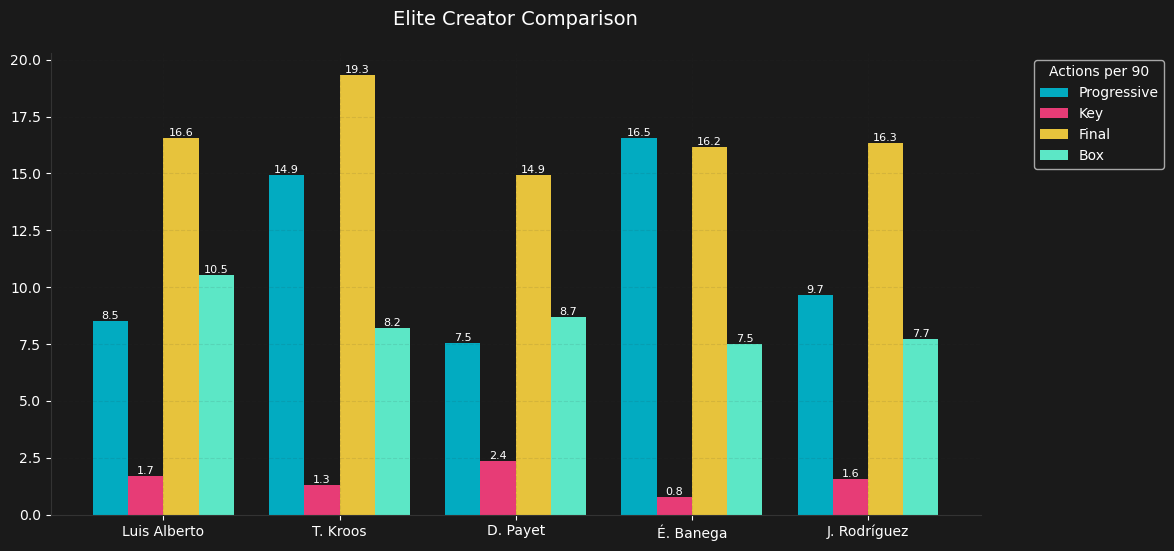

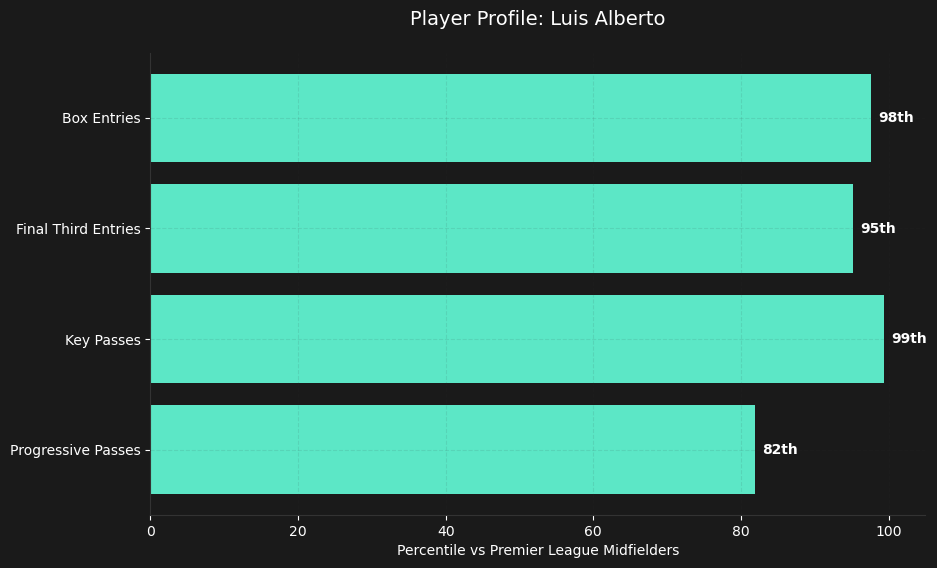

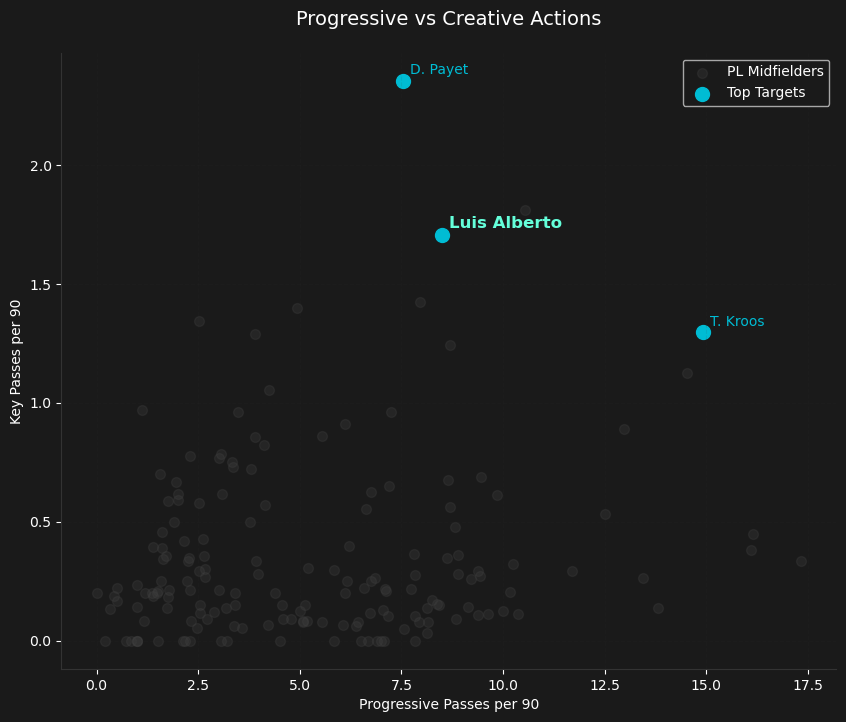

In [21]:
def create_clean_visualizations(foreign_targets, pl_stats):
    """Create enhanced football analytics visualizations with professional color scheme"""
    # Modern, professional color palette
    colors = {
        'background': '#1a1a1a',   # Dark background
        'text': '#ffffff',         # White text
        'grid': '#333333',         # Dark grid
        'metric_colors': {
            'Progressive': '#00bcd4',  # Cyan
            'Key': '#ff4081',         # Pink
            'Final': '#ffd740',       # Amber
            'Box': '#64ffda'          # Teal
        },
        'highlight': '#00bcd4',     # Cyan for highlights
        'secondary': '#ff4081',     # Pink for secondary
        'pl_scatter': '#404040',    # Dark gray for PL players
        'percentile': {
            'high': '#64ffda',      # Teal for high percentiles
            'medium': '#00bcd4',    # Cyan for medium
            'low': '#ff4081'        # Pink for low
        }
    }
    
    # Automatically identify best player
    best_player = foreign_targets.nlargest(1, 'composite_score').iloc[0]
    
    # Set style
    plt.style.use('dark_background')
    plt.rcParams.update({
        'figure.facecolor': colors['background'],
        'axes.facecolor': colors['background'],
        'axes.edgecolor': colors['grid'],
        'axes.labelcolor': colors['text'],
        'text.color': colors['text'],
        'xtick.color': colors['text'],
        'ytick.color': colors['text'],
        'grid.color': colors['grid'],
        'figure.figsize': [10, 6],
        'axes.grid': True,
        'grid.alpha': 0.2,
        'font.family': 'sans-serif',
        'axes.spines.top': False,
        'axes.spines.right': False,
    })
    
    # 1. Performance Overview
    plt.figure(figsize=(12, 6))
    top_5 = foreign_targets.nlargest(5, 'composite_score')
    
    metrics = ['progressive_passes_per90', 'key_passes_per90', 
              'final_third_passes_per90', 'box_entries_per90']
    
    x = np.arange(len(top_5))
    width = 0.2
    
    # Create grouped bars with distinct colors
    for i, (metric, color_key) in enumerate(zip(metrics, colors['metric_colors'].keys())):
        bars = plt.bar(x + width*i, top_5[metric], width, 
                      label=f'{color_key}',
                      color=colors['metric_colors'][color_key],
                      alpha=0.9)
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}',
                    ha='center', va='bottom',
                    color=colors['text'],
                    fontsize=8)
    
    # Customize appearance
    plt.xticks(x + width*1.5, top_5['shortName'], rotation=0, fontsize=10)
    legend = plt.legend(title='Actions per 90', bbox_to_anchor=(1.05, 1))
    legend.get_title().set_color(colors['text'])
    plt.title('Elite Creator Comparison', fontsize=14, pad=20)
    plt.grid(True, alpha=0.1, linestyle='--')
    
    # 2. Percentile Profile
    plt.figure(figsize=(10, 6))
    
    metrics_dict = {
        'Progressive Passes': 'progressive_passes_per90',
        'Key Passes': 'key_passes_per90',
        'Final Third Entries': 'final_third_passes_per90',
        'Box Entries': 'box_entries_per90'
    }
    
    # Calculate percentiles
    percentiles = {name: stats.percentileofscore(pl_stats[metric], 
                                               best_player[metric])
                  for name, metric in metrics_dict.items()}
    
    # Create horizontal bars with gradient colors
    y_pos = range(len(percentiles))
    bars = plt.barh(y_pos, list(percentiles.values()),
                   color=[colors['percentile']['high'] if v >= 80
                         else colors['percentile']['medium'] if v >= 60
                         else colors['percentile']['low'] for v in percentiles.values()],
                   alpha=0.9)
    
    # Add labels and percentile values
    plt.yticks(y_pos, list(percentiles.keys()), fontsize=10)
    for i, v in enumerate(percentiles.values()):
        plt.text(v + 1, i, f'{v:.0f}th',
                va='center', color=colors['text'],
                fontweight='bold', fontsize=10)
    
    plt.xlim(0, 105)
    plt.title(f'Player Profile: {best_player["shortName"]}',
              fontsize=14, pad=20)
    plt.xlabel('Percentile vs Premier League Midfielders', fontsize=10)
    plt.grid(True, alpha=0.1, linestyle='--')
    
    # 3. Scatter Plot
    plt.figure(figsize=(10, 8))
    
    # Plot PL players
    plt.scatter(pl_stats['progressive_passes_per90'],
               pl_stats['key_passes_per90'],
               alpha=0.3, color=colors['pl_scatter'],
               s=50, label='PL Midfielders')
    
    # Plot top 3 targets
    top_3 = foreign_targets.nlargest(3, 'composite_score')
    scatter = plt.scatter(top_3['progressive_passes_per90'],
                         top_3['key_passes_per90'],
                         color=colors['highlight'],
                         s=100, label='Top Targets')
    
    # Add annotations with distinct styling
    for _, player in top_3.iterrows():
        if player['shortName'] == best_player['shortName']:
            color = colors['percentile']['high']
            fontweight = 'bold'
            fontsize = 12
        else:
            color = colors['highlight']
            fontweight = 'normal'
            fontsize = 10
            
        plt.annotate(player['shortName'],
                    (player['progressive_passes_per90'],
                     player['key_passes_per90']),
                    xytext=(5, 5), textcoords='offset points',
                    color=color, fontweight=fontweight,
                    fontsize=fontsize)
    
    plt.xlabel('Progressive Passes per 90', fontsize=10)
    plt.ylabel('Key Passes per 90', fontsize=10)
    plt.title('Progressive vs Creative Actions',
              fontsize=14, pad=20)
    plt.grid(True, alpha=0.1, linestyle='--')
    plt.legend()
    
    # Print analysis
    print("\nRECRUITMENT ANALYSIS SUMMARY")
    print("=" * 40)
    
    print(f"\nTOP RECOMMENDATION: {best_player['shortName']}")
    print(f"League: {best_player['league']}")
    
    print("\nPerformance Profile:")
    for metric_name, metric in metrics_dict.items():
        perc = stats.percentileofscore(pl_stats[metric], best_player[metric])
        rating = "Elite" if perc >= 80 else "Strong" if perc >= 60 else "Average"
        print(f"• {metric_name}: {rating} ({perc:.0f}th percentile)")
    
    print(f"\nComposite Score: {best_player['composite_score']:.2f}")
    
    # Calculate key strengths
    top_attributes = sorted(percentiles.items(), key=lambda x: x[1], reverse=True)[:2]
    print("\nKey Strengths:")
    for attribute, percentile in top_attributes:
        print(f"• {attribute}: Top {100-percentile:.0f}% in Premier League")
    
    return plt

# Generate visualizations
visualizations = create_clean_visualizations(foreign_targets, player_rankings)